In [94]:
import numpy as np
from scipy.stats import pearsonr
from scipy import sparse
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import itertools
from ipywidgets import *
from functions import *

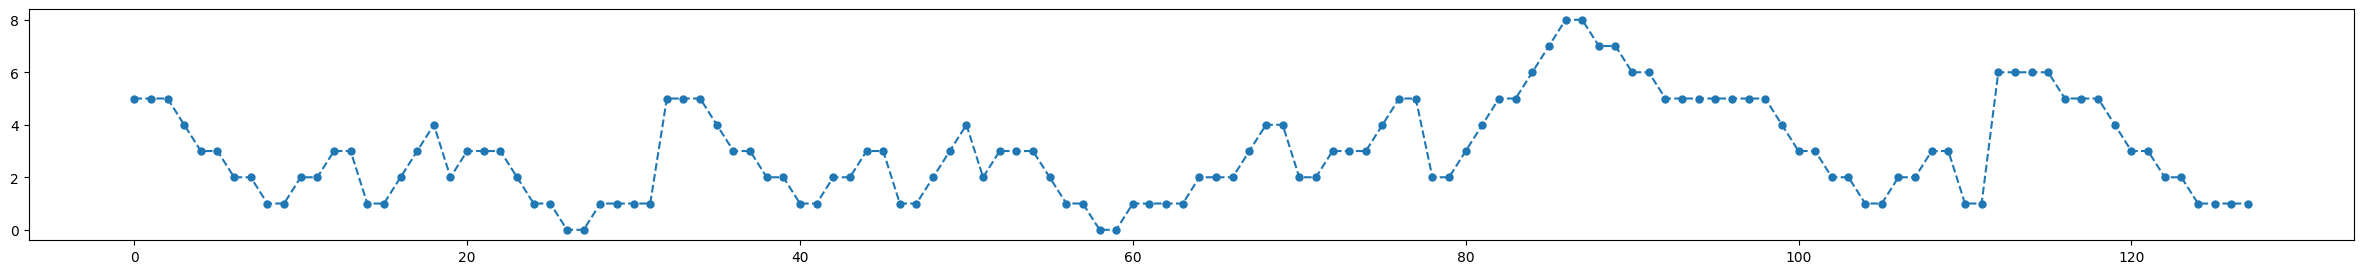

In [24]:
notes=[]
ss= '5  43 2 1 2 3 1 23423  21 0 1   5  43 2 1 2 3 1 23423  21 0 1   2  34 2 3  45 2 345 678 7 6 5   5  43 2 1 2 3 1 66665  43 2 1   '
for elem in ss:
    if elem.isnumeric():
        notes.append(int(elem))
    else:
        notes.append(notes[-1])

notes=np.array(notes)
m = notes.size
        
plt.figure(figsize=(30,3))
plt.plot(notes,linestyle='--', marker='.',markersize=10)

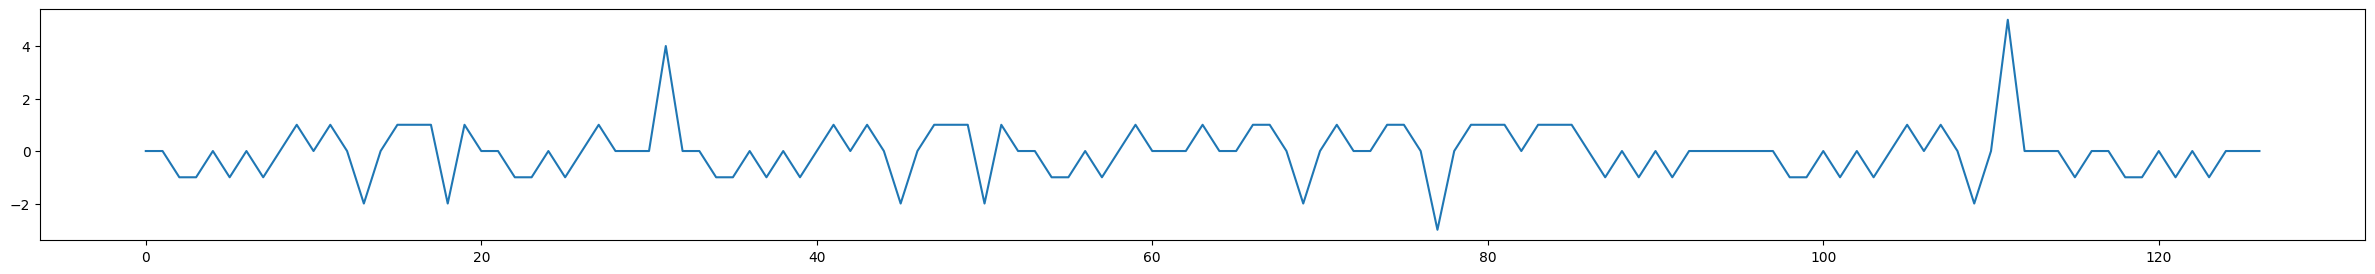

In [25]:
intervals = notes[1:] - notes[:-1]
plt.figure(figsize=(30,3))
plt.plot(intervals)
dataset=intervals

### The Class motif learning

In [125]:
class MotifLearner:

    def __init__(
        self,  
        sim_thresh=1, 
        freq_thresh=2, 
        l_motif_range = [4,20],
    ):
        self.dataset = dataset
        self.sim_thresh = sim_thresh
        self.freq_thresh = freq_thresh
        self.l_motif_range = l_motif_range
        self.iterator = range(self.l_motif_range[0], self.l_motif_range[1])
        self.m = len(self.dataset)
        
    
    def sim(self, u, v):
        """ Computes the Matching similarity function between two given vectors

        Parameters
        ----------
        X : {int-list}
        Y : {int-list} of same length as X

        Returns
        -------
        similarity : {float} that equals the propotion of matching entries between X and Y.

        """
        return sum([i==j for i, j in zip(u,v)])/len(u)

    def sim_matrix(self, l_motif):
        """ Computes the l_motif similarity matrix on a given dataset 

        Parameters
        ----------
        self.dataset : {array-like} of shape (n_samples,) containing the Training data time-series.
        l_motif : {int} specifying the motif length

        Returns
        -------
        similarity matrix: {float-matrix} of shape (n_samples, n_samples). Similarity matrix for the dataset for motifs of length l_motif

       """
        sim_mtx = np.zeros((self.m-l_motif,self.m-l_motif))
        for i in range(self.m-l_motif):
            for j in range(self.m-l_motif):
                u = self.dataset[i:i+l_motif]
                v = self.dataset[j:j+l_motif ]
                sim_mtx[i,j] = self.sim(u,v)
        sim_mtx = np.pad(sim_mtx, [(0, l_motif), (0, l_motif)], mode='constant', constant_values=0)
        return sim_mtx
    
    def fit(self, dataset):
        """ Method for finding motifs in the dataset in the given range of motif lengths

        Parameters
        ----------
        self.dataset : {array-like} of shape (n_samples,) containing the Training data time-series.
        self.sim_thresh : {float} specifies the threshold for the similarity matrix. Only if the similarity is greater than or equal to sim_thresh, will the motifs be considered equivalent
        self.freq_thresh: {int} specifies the minimum number of occurences for motif to considered frequent  
        self.l_motif_range: {int-list} of size 2. Specifies the range in which to search for motifs of length.

        Returns
        -------
        self : object
        Fitted estimator.
        
        It primarily estimates and stores in the class,
        frequent: {dict} that contains information of the frequent motifs, their start-point in the data, and their frequencies in the form:
                    {
                    1: {start_1_motif_1: freq of 1_motif_1, start_1_motif_2: freq of 1_motif_2, ...}
                    2: {start_2_motif_1: freq of 2_motif_1, start_2_motif_2: freq of 2_motif_2, ...}
                    .
                    .
                    .
                    l_motif: start_l_motif_1: freq of l_motif_1, start_l_motif_2: freq of l_motif_2, ...}
                    .
                    .
                    .
                    }
                    if there are no motifs of length l_i, then the corresponding value for entry l in dictionary is an empty dictionary

        """
        frequent={}
        for i in self.iterator:
            frequent[i]={}

        for l_motif in self.iterator:
            M = sim_matrix(self.dataset, l_motif) >= self.sim_thresh
            M = sparse.csr_matrix(M)
            sparse.csr_matrix.setdiag(M,0)
            def is_lonely_point(i,j):  ### Function inside: should we define this as a separate method outside? but then M would need to be an argument
                if i==0 or j==0:
                    return not (M[i+1,j+1])
                if i==M.shape[0]-1 or j==M.shape[0]-1:
                    return not (M[i-1,j-1])
                return not (M[i+1,j+1] or M[i-1,j-1]) 

            row, _ = M.nonzero()
            rows = set(row)
            while rows:
                i = rows.pop()
                c_lonely = 0
                c_total = 0
                for j in M[i,:].nonzero()[1]:
                    if is_lonely_point(i,j):
                        c_lonely+=1
                    else:
                        c_total+=1
                if c_lonely >= self.freq_thresh:
                    c_total+=c_lonely
                    frequent[l_motif][i]=c_total+1
                    ####### Comment out following lines if you want to be very careful that you don't remove compound motifs or something.
                    ####### Done very precisiely one would remove only the lonely points, but here we remove all just for cleaner results
                    ####### this may not always work
                    for point in M[i,:].nonzero()[1]: 
                        try:
                            rows.remove(point)
                        except:
                            pass
                    ########
                    ########
                    ########
        self.frequent = frequent
        return self
    
    def get_motifs(self, plot=False):
        """ Method that returns the actual motifs

        Parameters
        ----------
        plot : {bool} True creates plots of each of the frequent l-motifs
        
        Returns
        -------
        self : {list} of frequent motifs

        """
        self.motif_list = []
        for l_motif in self.iterator:
            if frequent[l_motif]!={}:
                if plot:
                    plt.figure()
                for key in frequent[l_motif]:
                    self.motif_list.append(list(dataset[key:key+l_motif]))
                    if plot:
                        plt.plot(dataset[key:key+l_motif])
                        plt.title(f'{l_motif}-motifs')
        return self.motif_list


    
    def matrix_plot(plot=True):
        """
        Method that plots and visualises the similarity matrix for the given dataset and sim_thresh
        
        """
        def mplot(l_motif):
            sim_mtx = self.sim_matrix(l_motif)
            if plot:
                plt.figure(figsize=(8,10))
                plt.imshow(sim_mtx,cmap='Greys')
                plt.figure(figsize=(8,2))
                #plt.plot(notes,linestyle='--', marker='.',markersize=5)
                #plt.xlim(0,notes.shape[0])
                plt.show()
            return sim_mtx

        interactive_plot = interactive(mplot, l_motif=(1, 40))
        output = interactive_plot.children[-1]
        return interactive_plot

In [126]:
motifl = MotifLearner(
        sim_thresh=1, 
        freq_thresh=2, 
        l_motif_range = [4,20])
motifl.fit(dataset)
motifl.get_motifs()

[[-1, 0, -1, 0],
 [0, 1, 1, 1],
 [0, 1, 0, 0],
 [0, -1, 0, 0],
 [1, 0, -2, 0, 1],
 [0, -1, 0, -1, 0],
 [-1, 0, -1, 0, 1, 0],
 [-1, 0, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0, -1, 0],
 [0, 0, -1, -1, 0, -1, 0, -1, 0, 1, 0, 1, 0, -2, 0]]

In [127]:
motifl.frequent

{4: {3: 12, 14: 4, 26: 4, 114: 3},
 5: {67: 3, 86: 6},
 6: {5: 5, 87: 5},
 7: {0: 6},
 8: {},
 9: {116: 4},
 10: {},
 11: {},
 12: {},
 13: {},
 14: {},
 15: {96: 3},
 16: {},
 17: {},
 18: {},
 19: {}}

In [128]:
motifl.matrix_plot()

interactive(children=(IntSlider(value=20, description='l_motif', max=40, min=1), Output()), _dom_classes=('wid…

In [129]:
### Pruning out sub-motifs

def is_submotif(big_motif,small_motif):
    for i, _ in enumerate(big_motif):
        if np.array_equal(big_motif[i:i+len(small_motif)],small_motif):
            return True
    return False

duplicate_motifs = []
for l_motif in reversed(iterator):
    for key1 in list(frequent[l_motif].keys()):
        big_motif = dataset[key1:key1+l_motif]
        flag = True
        for s_motif in reversed(range(iterator.start,l_motif)):
            for key2 in list(frequent[s_motif].keys()):
                small_motif = dataset[key2:key2+s_motif]
                if is_submotif(big_motif,small_motif):
                    frequent[s_motif].pop(key2)
                    duplicate_motifs.append((big_motif, key2))
for l_motif in iterator:
    #plt.figure()
    for key in frequent[l_motif]:
        print(dataset[key:key+l_motif])
        #plt.plot(dataset[key:key+l_motif])
        #plt.title(f'{l_motif}-motifs')

duplicate_motifs

[0 1 1 1]
[0 1 0 0]
[ 0 -1  0  0]
[ 1  0 -2  0  1]
[ 0  0 -1 -1  0 -1  0 -1  0  1  0  1  0 -2  0]


[(array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 116),
 (array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 0),
 (array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 5),
 (array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 87),
 (array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 86),
 (array([ 0,  0, -1, -1,  0, -1,  0, -1,  0,  1,  0,  1,  0, -2,  0]), 3)]

----------------

### Some visualisations

In [15]:
sim_matrix(dataset,l_motif=6)

array([[1.        , 0.33333333, 0.5       , ..., 0.        , 0.        ,
        0.        ],
       [0.33333333, 1.        , 0.16666667, ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.16666667, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [17]:
matrix_plot(l_motif=6, plot=False)

array([[ True, False, False, ..., False, False, False],
       [False,  True, False, ..., False, False, False],
       [False, False,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [81]:
### Plotting the similatrity matrix
def matrix_plot(l_motif, plot=True):
    m = len(dataset)
    sim_mtx = np.zeros((m-l_motif,m-l_motif))
    for i in range(m-l_motif):
        for j in range(m-l_motif):
            u = dataset[i:i+l_motif]
            v = dataset[j:j+l_motif]
            sim_mtx[i,j] = sim(u,v)
    sim_mtx = np.pad(sim_mtx==1, [(0, l_motif), (0, l_motif)], mode='constant', constant_values=0)
    if plot:
        plt.figure(figsize=(8,10))
        plt.imshow(sim_mtx,cmap='Greys')
        plt.figure(figsize=(8,2))
        plt.plot(notes,linestyle='--', marker='.',markersize=5)
        plt.xlim(0,notes.shape[0])
        plt.show()
    return sim_mtx

interactive_plot = interactive(matrix_plot, l_motif=(1, 40))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=20, description='l_motif', max=40, min=1), Checkbox(value=True, descript…

In [10]:
def matrix_plot_frequents(l_motif):
    M = sim_matrix(dataset, l_motif)==1
    motif_mat = []
    thresh = 5
    for i, row in enumerate(M):
        if np.sum(row==1) > max(3, thresh-l_motif):
            motif_mat.append(row)
    plt.figure(figsize=(15,3))
    plt.plot(dataset,linestyle='-', marker='o')
    plt.xlim(0,len(dataset))
    plt.figure(figsize=(15,3))
    try:
        plt.imshow(motif_mat, cmap='Greys', aspect='auto')
    except:
        print("No motifs for selected l_motif!")
    plt.figure(figsize=(15,3))
    plt.xlim(0,len(dataset))
    plt.plot(np.array(motif_mat).sum(axis=0), linestyle='--',marker='.')
    return motif_mat

interactive_plot = interactive(matrix_plot_frequents, l_motif=(1, 20))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=10, description='l_motif', max=20, min=1), Output()), _dom_classes=('wid…

In [11]:
def l_motif_mat(l_motif):
    M = sim_matrix(dataset, l_motif)==1
    motif_mat = []
    motif_start = []
    thresh = 5
    for i, row in enumerate(M):
        if np.all(row[:i]==0) and np.sum(row==1) > max(3, thresh-l_motif):
            motif_mat.append(row)
            motif_start.append(i)
    motif_mat = np.array(motif_mat)
    motif_start = np.array(motif_start)
    
    plt.figure(figsize=(10,1))
    try:
        plt.imshow(motif_mat,cmap='Greys',aspect='auto')
    except:
        print("No motifs for selected l_motif!")

    return motif_mat, motif_start


interactive_plot = interactive(l_motif_mat, l_motif=(1, 20))
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(IntSlider(value=10, description='l_motif', max=20, min=1), Output()), _dom_classes=('wid…

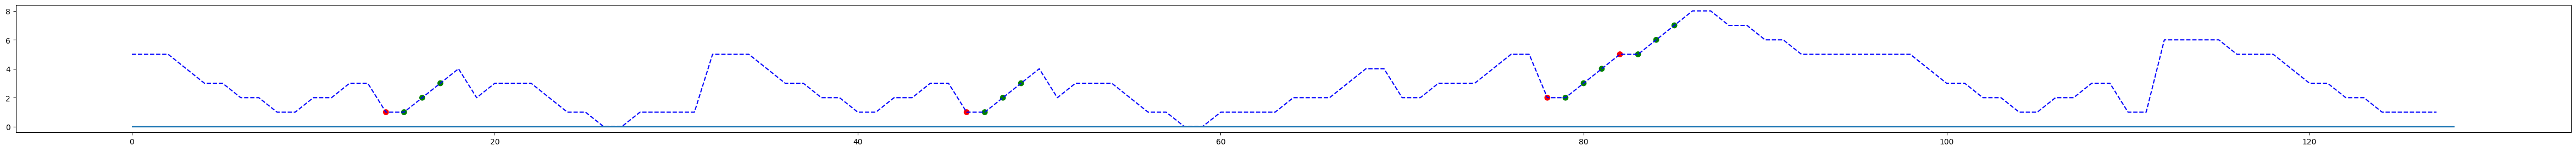

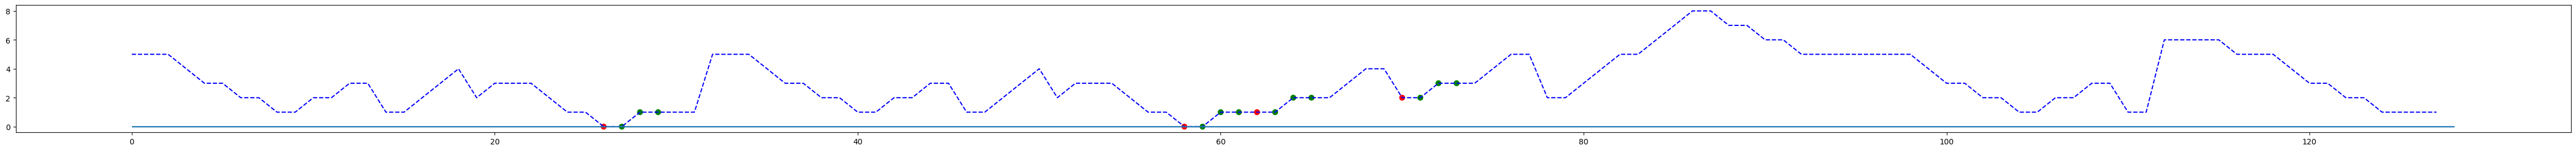

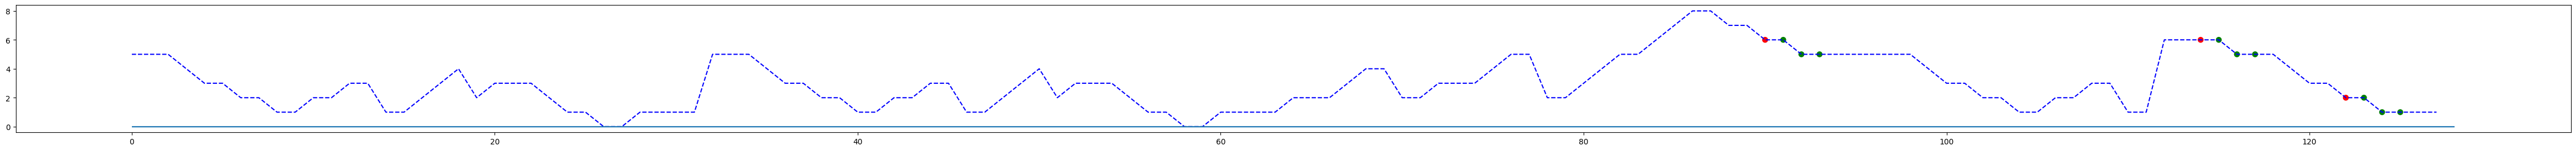

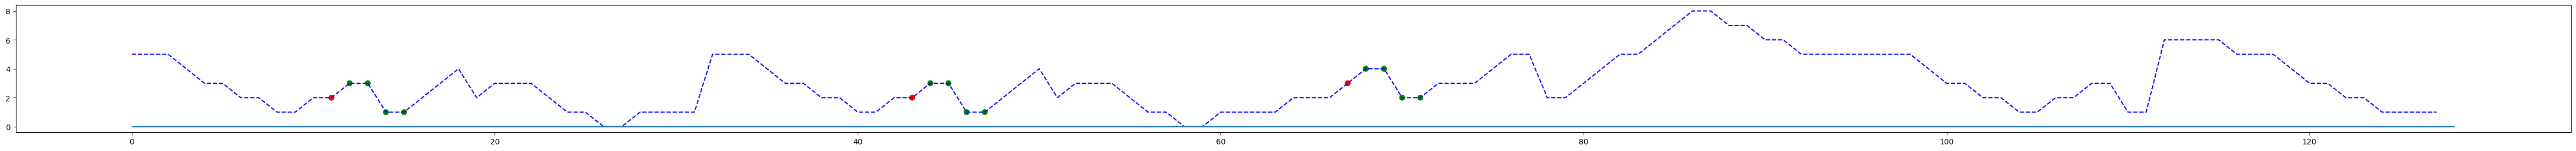

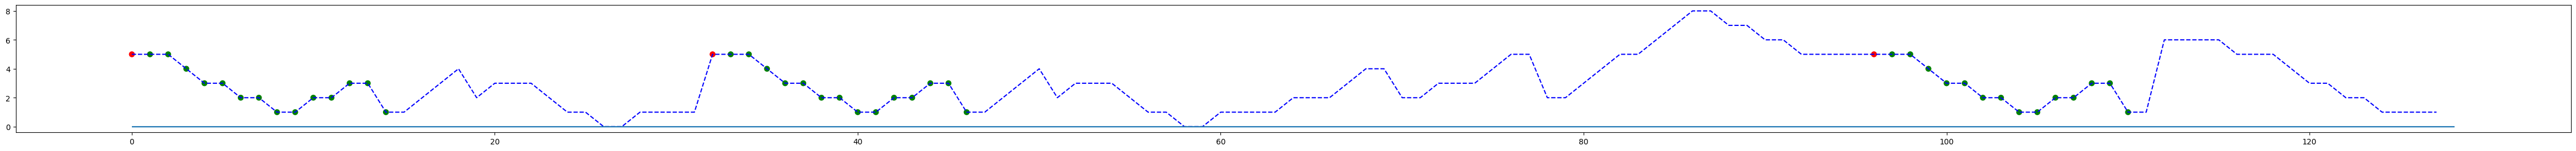

In [15]:
def plot_motif_appearances_notes(motif):
    plt.figure(figsize=(60,3))
    plt.plot(np.arange(len(notes)), notes,c='b', linestyle='--')
    for i, _ in enumerate(dataset[:-len(motif)]):
        if sim(dataset[i:i+len(motif)], motif)==1:
            plt.scatter(np.arange(i,i+len(motif)),notes[i:i+len(motif)], c=['r']+['g']*(len(motif)-1),s=45)
            plt.hlines(y=0,xmin=0, xmax=len(notes))

for l_motif in iterator:    
    for key in frequent[l_motif]:
        motif = dataset[key:key+l_motif]
        plot_motif_appearances_notes(motif)